## Air Quality in Vanderbijlpark Prediction (AUTO REGRESSION)

In [1]:
import warnings
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.ar_model import AutoReg
warnings.filterwarnings(action='ignore')

In [2]:

def wrangle(filename):
    #We read the filename into a dataframe and passing the ';' as a delimiter
    df = pd.read_csv(filename,delimiter=';')
    # We convert our timestamp column of object datatype to a timestamp datatype
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # We set the index of the dataframe to be the timestamp 
    df.set_index('timestamp',inplace=True)
    #We  convert the timestamp to the 'Africa/Johannesburg' timezone since the dataset is gotten from Vanderbijlpark
    df.index = df.index.tz_convert('Africa/Johannesburg')
    #Sort Our data Frame by index
    df = df.sort_index()
    #We mask our DataFrame to return value that contains the P2 value type
    mask = df['value_type'] == 'P2'
    df  = df[mask]
    ## we identify column with low and high cardinality and drop them
    low_cardinality_list = [column for column in df.columns if df[column].nunique() < 2 ]
    df.drop(low_cardinality_list,axis=1,inplace = True)
    # We resample the dataframe to return a series with the mean of the P2 value for every Hour
    y =  df['value'].resample('1H').mean().fillna(method ='ffill')
    y.name = 'P2'
    return y
    

### 1. IMPORT

In [3]:
#Returns all files that matches the pattern as specified in the glob function argument
files = glob('data/*_2021_sensor_data_archive.csv')

In [4]:
#A list comprehension for that perform the wrangle function for each file in the list created by glob funtion
list_of_df = [wrangle(file) for file in files]
# We concatenate the list of dataframes into one dataframe using the pd.concat method and set index to the timestamp
y = pd.concat(list_of_df).sort_index()

### 2. EXPLORE

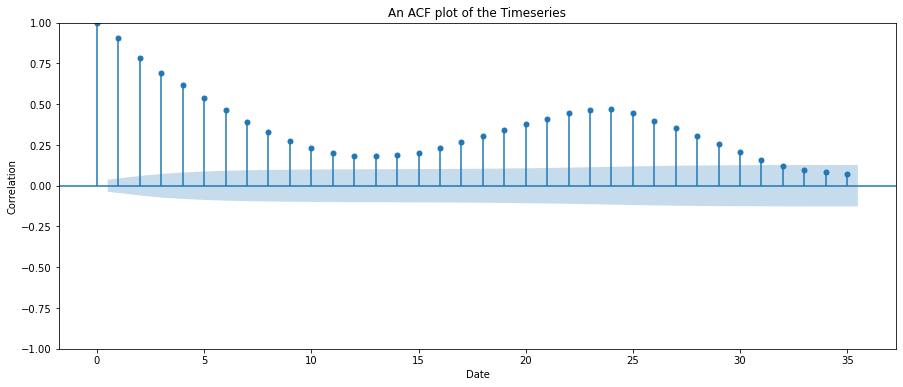

In [5]:
# An ACF plot for the correlation of the series for each lags
fig,ax = plt.subplots(figsize=(15,6))
plot_acf(y,ax=ax)
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('An ACF plot of the Timeseries');

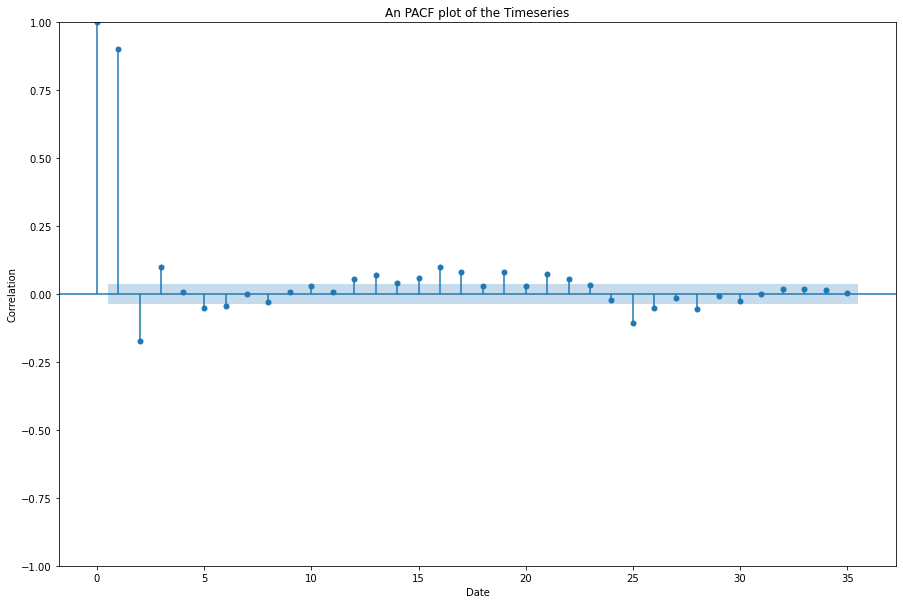

In [6]:
# An PACF plot for the correlation of the series for each lags
fig,ax = plt.subplots(figsize=(15,10))
plot_pacf(y,ax=ax)
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.title('An PACF plot of the Timeseries');

### 3. SPLIT

In [7]:
#We split our y data into train and test set
cut_off = int(len(y)*0.8)
y_train = y[:cut_off]
y_test = y[cut_off:]

### 4. BUILD MODEL

#### A. BASELINE

In [8]:
# We create a baseline model which would be used to test how well our test data those.
# The baseline will be the mean absolute error of y_train against that of y_mean
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
y_baseline_df = pd.DataFrame({'y_train' : y_train,'y_baseline':y_pred_baseline})
mae = mean_absolute_error(y_train,y_pred_baseline)
print(f' The mean of the y_train is {y_mean}')
print(f' The mean absolute error of the baseline model is {mae}')

 The mean of the y_train is 49.350895176096344
 The mean absolute error of the baseline model is 28.48940505651164


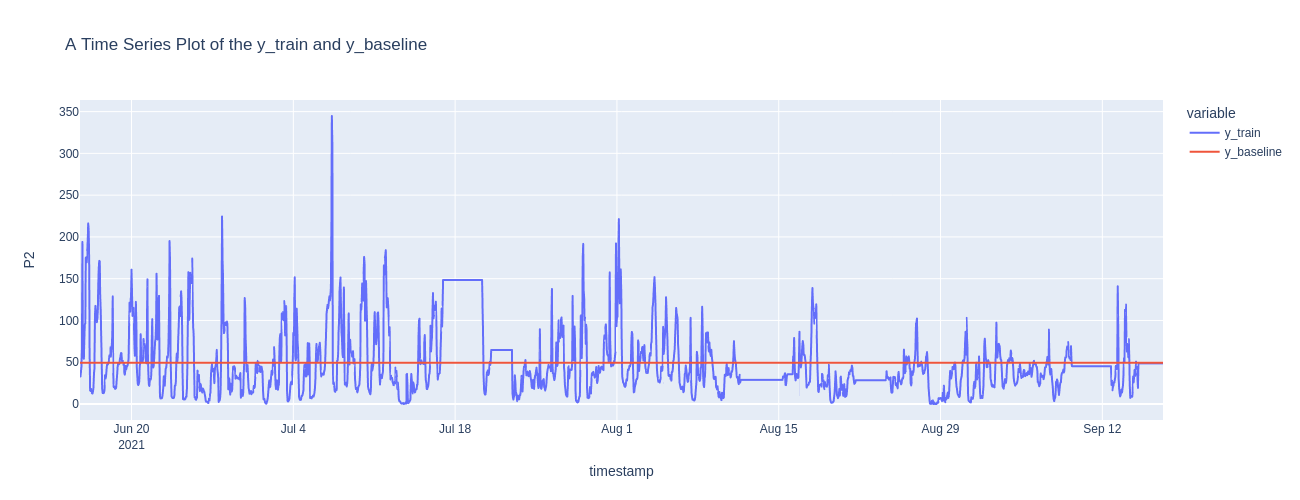

In [9]:
fig = px.line(y_baseline_df,labels={'value':'P2'},title='A Time Series Plot of the y_train and y_baseline',width=1300)
fig.show('png');

#### B. AUTO REGRESSION MODEL

In [10]:
# We instantiate our Auto regression model and set the lags to the max number of lag that produced a good correlation in pacf plot
lags = 26
auto_reg_model = AutoReg(y_train,lags=lags).fit()

In [11]:
#We Generate predictions for the fitted data and calculate the mae
y_train_pred = auto_reg_model.predict().dropna()
auto_reg_model_mae = mean_absolute_error(y_train[lags:],y_train_pred)
print(f' The mean absolute error of the Auto Regression model with the train test is {auto_reg_model_mae}')


 The mean absolute error of the Auto Regression model with the train test is 8.705522711258446


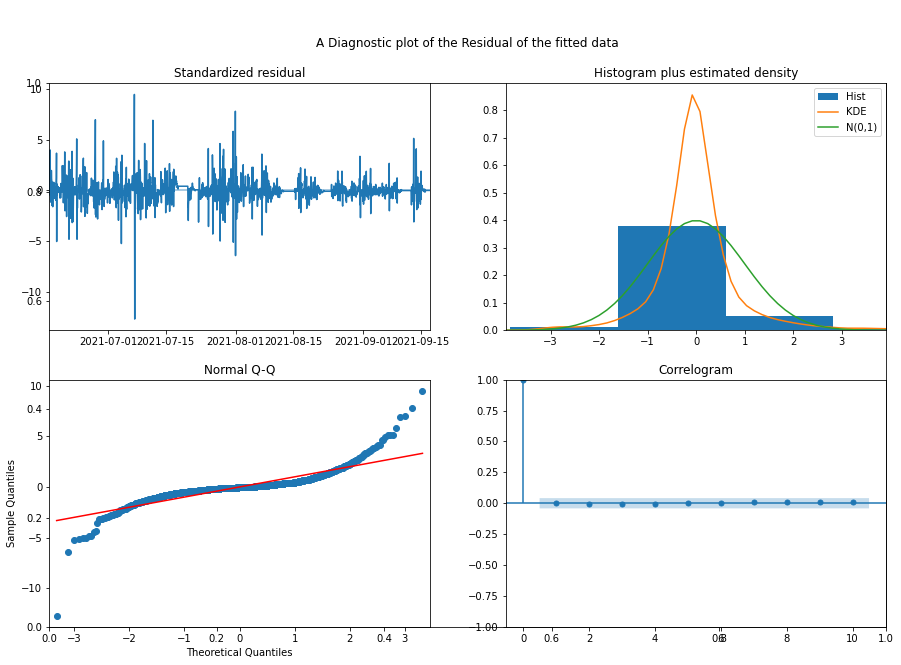

In [12]:
#We create a timeseries plot,an histogram and q-q plot to check for normality and an acf plot to check if the residual have any correlation.
fig,ax = plt.subplots(figsize=(15,10))
plt.title('\n\nA Diagnostic plot of the Residual of the fitted data\n\n')
auto_reg_model.plot_diagnostics(fig=fig);

In [13]:
# We generate the prediction of the test set and check for the mean absolute error.
y_test_pred = auto_reg_model.predict(y_test.index.min(),y_test.index.max())
auto_reg_model_test_mae = mean_absolute_error(y_test,y_test_pred)
print(f' The mean absolute error of the Auto Regression model with the test set is {auto_reg_model_test_mae}')

 The mean absolute error of the Auto Regression model with the test set is 21.108741268665053


In [14]:
# We create a DataFrame for the predicted test set and the True test set
y_test_pred_df = pd.DataFrame({
    'y_test':y_test,
    'y_test_pred':y_test_pred
})
y_test_pred_df.head()

,y_test,y_test_pred
2021-09-17 07:00:00+02:00,48.680000,48.660673
2021-09-17 08:00:00+02:00,23.063846,48.640693
2021-09-17 09:00:00+02:00,29.938868,48.625408
2021-09-17 10:00:00+02:00,23.692000,48.613336
2021-09-17 11:00:00+02:00,12.362353,48.602114


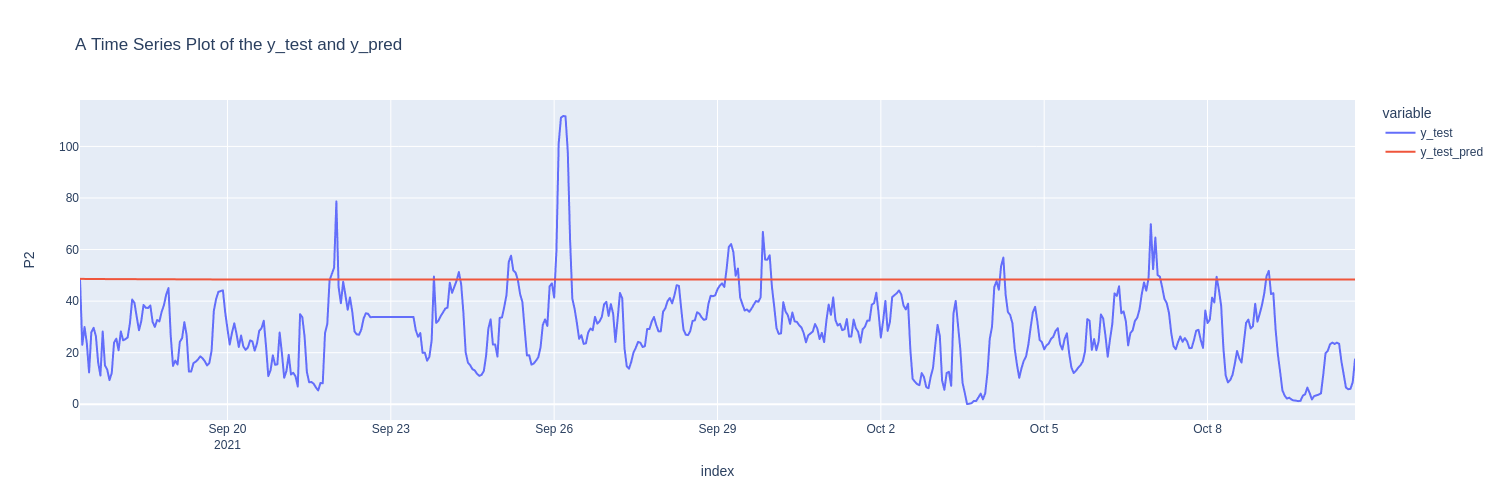

In [15]:
fig = px.line(y_test_pred_df,labels={'value':'P2'},title='A Time Series Plot of the y_test and y_pred',width=1500)
fig.show('png');

#### C. AUTOREGRESSION WITH WALK-FORWARD VALIDATION

In [16]:
# Next we perform a walk forward validation for the entire test set. We create a function
def walk_forward_validation(y_train,y_test):
    y_pred_wfv = pd.Series()
    history = y_train.copy()
    for i in range(len(y_test)):
        model = AutoReg(history,lags = lags).fit()#lags  is 26
        next_pred = model.forecast()
        y_pred_wfv = y_pred_wfv.append(next_pred)
        history = history.append(y_test[next_pred.index])
    return y_pred_wfv,model

In [17]:
y_pred_wfv,model = walk_forward_validation(y_train,y_test)

In [18]:
# We generate the prediction of the test set and check for the mean absolute error.
auto_reg_model_test_mae = mean_absolute_error(y_test,y_pred_wfv)
print(f' The mean absolute error of the Auto Regression model with the test set is {auto_reg_model_test_mae}')

 The mean absolute error of the Auto Regression model with the test set is 4.899789647343407


### 5. COMMUNICATE RESULTS

In [19]:
#Next we print out the coefficient of the model used
def print_model_equation(model):
    model_dict = dict(model.params)
    equation = ''
    equation = equation + f"{model_dict['const']}"
    for key,value in model_dict.items():
        if key != 'const' and value > 0:
            equation = equation + f' + {value}*{key}'
        elif key != 'const' and value < 0:
            equation = equation + f' {value}*{key}'
    return equation

In [20]:
print_model_equation(model)

'2.673230279691193 + 1.0360957358408964*P2.L1 -0.27356647887249613*P2.L2 + 0.09371342000397133*P2.L3 + 0.05146252661686495*P2.L4 + 0.0003371567035019129*P2.L5 -0.03283541743929634*P2.L6 + 0.0052258797819242486*P2.L7 + 0.010195436037892623*P2.L8 -0.034751202426053354*P2.L9 + 0.030806671267089494*P2.L10 -0.03056574826391513*P2.L11 -0.026456790392674692*P2.L12 + 0.036658211980181474*P2.L13 -0.022555162835412694*P2.L14 + 0.005941636829843198*P2.L15 -0.004815712903375152*P2.L16 + 0.07142521658763576*P2.L17 -0.06184972606070449*P2.L18 + 0.06607210041581911*P2.L19 -0.04434150169437843*P2.L20 + 0.03721819687098188*P2.L21 + 0.022636251822818053*P2.L22 + 0.030143024268404456*P2.L23 + 0.0788650650784175*P2.L24 -0.05671843374193319*P2.L25 -0.04906958945049419*P2.L26'

In [21]:
# We create a DataFrame for the predicted test set and the True test set
y_test_pred_df = pd.DataFrame({
    'y_test':y_test,
    'y_pred_wfv':y_pred_wfv
})
y_test_pred_df.head()

,y_test,y_pred_wfv
2021-09-17 07:00:00+02:00,48.680000,48.660673
2021-09-17 08:00:00+02:00,23.063846,48.660681
2021-09-17 09:00:00+02:00,29.938868,22.168330
2021-09-17 10:00:00+02:00,23.692000,36.392741
2021-09-17 11:00:00+02:00,12.362353,25.618006


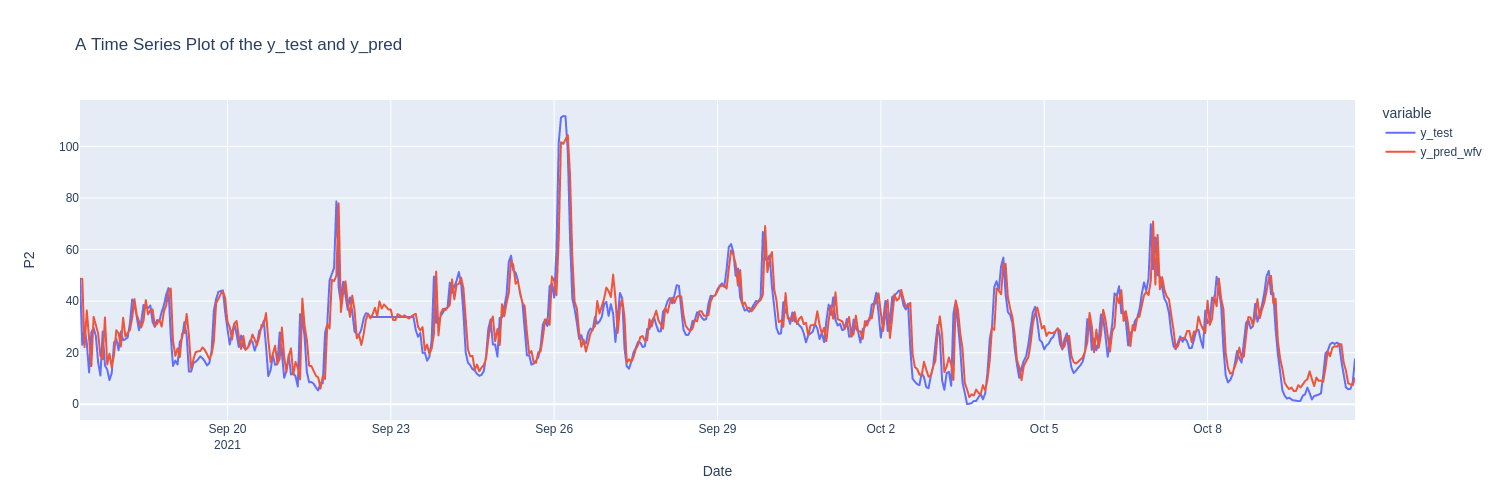

In [22]:
fig = px.line(y_test_pred_df,labels={'value':'P2','index':'Date'},title='A Time Series Plot of the y_test and y_pred',width=1500)
fig.show('png');